## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math
import time

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Load Data

In [2]:
# loading entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/trajectories/'
trajectories = os.listdir(path)

## Data Cleansing

In [3]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i, time_bin in enumerate(trajectories):
    trajectory = loadmat(path + time_bin)
    trajectory = trajectory['trajectory'] 
    for i in range(trajectory.shape[1]):
        if np.isnan(trajectory[:, i]).all():
            nan_cols.append(i)

sampling_factor = 30
nan_cols = np.asarray(nan_cols)
if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
    sampled_trajectories = np.zeros(((trajectory.shape[0]*int(len(trajectories)/sampling_factor)), trajectory.shape[1]-3))
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-3))
    a = 0
    for i, time_bin in enumerate(trajectories):
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        trajectory = np.delete(trajectory, nan_cols, 1)
        idx = a*trajectory.shape[0]
        idx_2 = i*trajectory.shape[0]
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
        if i % sampling_factor == 0 and sampled_trajectories.shape[0]-idx >= trajectory.shape[0]:
            sampled_trajectories[idx:idx+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
            a+=1
        
print(sampled_trajectories.shape)
print(all_trajectories.shape)

(216000, 57)
(8100000, 57)


## First and Second Moment Analysis

In [7]:
# mean 
means = [np.mean(all_trajectories[:, i]) for i in range(all_trajectories.shape[1])]

# standard deviation
stds = [np.std(all_trajectories[:, i]) for i in range(all_trajectories.shape[1])]
max_dim_std = np.where(np.isclose(stds, max(stds)))
print(max_dim_std)


(array([18, 38, 46, 47, 56]),)


## Subsampling Frequency (using MI)

### Helper Functions

In [8]:
def probability(sequence, decimals=0):
    '''
    input: 
        - 1D sequence of rv observations
    return: 
        - probability vector
    '''
    
    if sequence.shape[0] < sequence.shape[1]:
        sequence = np.transpose(sequence)
    
    # round input sequence to avoid sparse probability vector
    sequence = np.round(sequence, decimals)
    unique = np.unique(sequence, axis=0)
    n_triplets = len(unique)

    # fill probability vector
    prob_vector = np.zeros((n_triplets, 1))
    for row in sequence:
        occurrences = len(np.where(np.all(np.isclose(sequence, row), axis=1))[0])
        idx = np.where(np.all(np.isclose(unique, row), axis=1))
        if prob_vector[idx[0]] == 0:
            prob_vector[idx[0]] = occurrences/(sequence.shape[0])
    return prob_vector

In [9]:
def joint_probability(*argv):
    '''
    input: 
        - sequence_1 of rv_1 observations
        - sequence_2 of rv_2 observations
        - number of dimensions of input sequences to consider(default = all)
    return: 
        - joint probability vector
    '''
    n_args = len(argv)
    if n_args == 2:
        s1 = argv[0]
        s2 = argv[1]
        dims = s1.shape[1]
        decimals = 0
        
    if n_args == 3:
        s1 = argv[0]
        s2 = argv[1]
        dims = argv[2]
        # select dims based on input
        s1 = s1[:, 0:dims]
        s2 = s2[:, 0:dims]
        decimals = 0
        
    # checking that the dimensions of the input sequences are in the right order
    if s1.shape[0] < s1.shape[1]:
        s1 = np.transpose(s1)
    if s2.shape[0] < s2.shape[1]:
        s2 = np.transpose(s2)
    
    s1 = np.around(s1, decimals)
    s2 = np.around(s2, decimals) 
    
    # here we assume that the input sequences are already rounded (n_observations x n_dimensions)
    unique_s1 = np.unique(s1, axis=0)
    n_triplets_s1 = len(unique_s1)
    unique_s2 = np.unique(s2, axis=0)
    n_triplets_s2 = len(unique_s2)
    
    joint_data = np.concatenate((s1, s2), axis=1)
    print('JOINT SPACE SIZE: ', joint_data.shape)
    
    # filling joint probability matrix
    joint_prob_matrix = np.zeros((n_triplets_s1, n_triplets_s2))
    occurrences, idx_s1, idx_s2 = 0, 0, 0
    for joint_array in joint_data:
        occurrences = len(np.where(np.all(np.isclose(joint_data, joint_array), axis=1))[0])
        idx_s1 = np.where(np.all(np.isclose(unique_s1, joint_array[0:dims]), axis=1))
        idx_s2 = np.where(np.all(np.isclose(unique_s2, joint_array[dims:2*dims]), axis=1))
        if joint_prob_matrix[idx_s1[0][0], idx_s2[0][0]] == 0:
            joint_prob_matrix[idx_s1[0][0], idx_s2[0][0]] = (occurrences/joint_data.shape[0])
            
    return joint_prob_matrix

In [10]:
def conditional_entropy(prob_s1s2, prob_s2):
    E_cond = 0
    for i in range(prob_s1s2.shape[0]):
        for j in range(prob_s1s2.shape[1]):
            E_cond += prob_s1s2[i,j] * math.log((prob_s2[j]/prob_s1s2[i,j]), 2)
            
    return E_cond

In [11]:
def joint_entropy(prob_s1s2):
    E_joint = 0
    for i in range(prob_s1s2.shape[0]):
        for j in range(prob_s1s2.shape[1]):
            if prob_s1s2[i,j] > 0:
                E_joint += prob_s1s2[i,j] * math.log((1/prob_s1s2[i,j]), 2)
            
    return E_joint

### Sub-sampling frequency vs MI

CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
JOINT SPACE SIZE:  (2700, 6)
1.0
CALCULATING ENTROPY VECTORS...
[3.241357] [4.43670625] [1.70766937]
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
JOINT SPACE SIZE:  (16200, 6)
1.0
CALCULATING ENTROPY VECTORS...
[3.28190768] [4.46312053] [1.81908424]
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
JOINT SPACE SIZE:  (30000, 6)
0.9999999999999999
CALCULATING ENTROPY VECTORS...
[3.28852722] [4.46226853] [1.84018058]
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
JOINT SPACE SIZE:  (45000, 6)
1.0000000000000002
CALCULATING ENTROPY VECTORS...
[3.28904233] [4.46683223] [1.84355093]
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
JOINT SPACE SIZE:  (57858, 6)
0.9999999999999999
CALCULATING ENTROPY VECTORS...
[3.28600945] [4.46733801] [1.84380132]
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBA

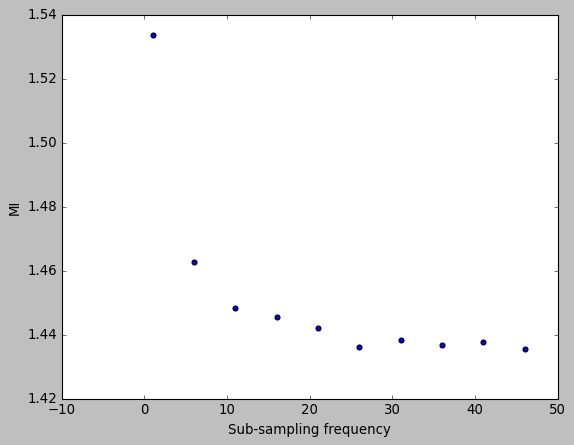

In [13]:
fs_og = 300
length_ = int(all_trajectories.shape[0]/10)
sub_fs = np.arange(1,50, 5)
names = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM',
         'SpineL', 'Offset1', 'Offset2', 'HipL', 'HipR',
         'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR'
         'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
markers = [11, 15]
MIs = np.zeros((len(sub_fs), 1))
for i, fs in enumerate(sub_fs):
    # step for sampling frequency
    step = int(300/fs)
    
    # construct sample trajectories for the first 2 dims ('HeadF' and 'HeadB')
    s1 = all_trajectories[0:length_:step, markers[0]*3:(markers[0]*3)+3]
    s2 = all_trajectories[0:length_:step, markers[1]*3:(markers[1]*3)+3]
            
    # probability vectors for the two sequences and joint probability
    print('CALCULATING PROBABILITY VECTORS...')
    prob_s1 = probability(s1)
    prob_s2 = probability(s2)
    print('CALCULATING JOINT PROBABILITY VECTORS...') 
    prob_s1s2 = joint_probability(s1, s2) 
    print(np.sum(prob_s1s2))
    
    # calculating entropy values for MI
    print('CALCULATING ENTROPY VECTORS...')
    E_s1 = entropy(prob_s1, base=2)
    E_s2 = entropy(prob_s2, base=2)
    E_s1_cond_s2 = joint_entropy(prob_s1s2) - E_s2
    print(E_s1, E_s2, E_s1_cond_s2)
    MI = E_s1 - E_s1_cond_s2
    MIs[i] = MI
    
# plotting relation between MI and sub-sampling frequency
plt.scatter(sub_fs, MIs)
plt.ylabel('MI')
plt.xlabel('Sub-sampling frequency')
plt.show()